# Final project: Temporal Link Prediction Model for Weighted Dynamic Networks

Welcome to our final project, we utilize GCN GAN to create this project.

In this version, the dataset that is used is USCB taken from the paper of _GCN-GAN_.

The USCB is a link-quality dataset of a wireless mesh network. The hosts in the network systems can be described as the nodes in the dynamic networks.

The statistic of UCSB is illustrated in Fig. 2 as an example, in which w (the horizontal axis) represents the possible edge weight value of the dataset, while c(w) represents the number of edges with value w. Note that we use the logarithm of c(w) as the vertical axis.
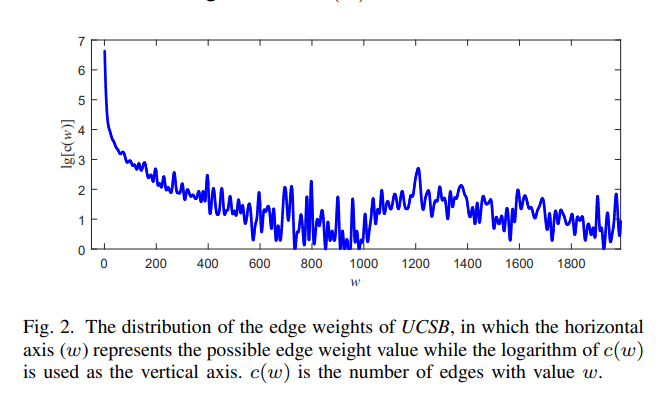


In the dataset of USCB, you can find 1005 files, of the edge list. 
In each file ther is three numbers:

- [X] _The first:_ is the index of the source node
- [X] _The second:_ is the index of the target node
- [X] _The third:_ is the weight of the edge, while of curse the maximum is _Threshold of the maximum edge weight = max_thres._



# Explain about our dataset:
the site we taken the datasets is: [figshare](https://nih.figshare.com/search?q=:keyword:%20%22Citation%20data%22)
and I select the smallest one so we can run it despite the lack of RAN & time: [iCite Database Snapshot 2020-04](https://nih.figshare.com/articles/dataset/iCite_Database_Snapshot_2020-04/12288581?file=22650896)

- open_citation_collection.csv: this file contin two column: 
        - citing
        - referenced
        
        and ther is about 1048576 rows.
        
- icite_metadata.csv: this file contian the articals:: title authors .. he data of        
  The data of 'open_citation_collection.csv' taken from the columns: 'pmid' and 'cited_by'.
  
so now all we need to do is to explain how to create a graphs from this OR to adjust this code to read the format of this dataset.
  

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import csv
import sys

#disabled v2 behavior to fix runtime bugs
tf.disable_v2_behavior()
tf.disable_eager_execution()

# set the csv file limt to be the maximum
csv.field_size_limit(sys.maxsize)

131072

# _utils:_ Function related to the dataset and initializations

In [2]:
def creat_file_cition(file_path):
    '''
    This function reads the network snapshot of a specific time slice and 
    generates a file containing only the source node and the target node. 
    In this case, the source node represents an article, 
    and the target node represents a reference within the source node.
    :param file_path: The file path of the snapshot.
    '''
    cition_file = open(txt_file_path, 'w')
    
    # Open the CSV file for reading
    with open(file_path, encoding="utf8") as csvfile:
        # Create a CSV reader object
        csvreader = csv.reader(csvfile, delimiter=',')
        # Use the next() function to skip the first row
        next(csvreader)
        # Iterate through each row in the CSV file
        for row in csvreader:
            src = int(row[0]) #Index of the source node
            referances = row[22].strip().split() # get the referances of the article

            for ref in referances:
                tar = int(ref) #Index of the target node
            
                # write the edge list to output file
                cition_file.write('%d %d' % (src, tar))
                cition_file.write('\n')
                
    cition_file.close()

In [3]:
def read_data(time_index, node_num, max_thres):
    '''
    Function to read the network snapshot of specific time slice
    and generate a random weight for each edge in the graph
    :param time_index: index of time slice
    :param node_num: number of nodes in the dynamic network
    :param max_thres: threshold of the maximum edge weight
    :return: adjacency matrix of the specific time slice
    '''
    print('Read network snapshot #%d'%(time_index))
    # Initialize the adjacency matrix
    curAdj = np.mat(np.zeros((node_num, node_num)))
    # Read the network snapshot of current time slice
    
    file_edgeList = open("edgeList_%d.txt"%(time_index),'w')
    
    # Open the CSV file for reading
    with open(txt_file_path, "r") as file:
        for line in file:
            # src index of the source node
            # tar index of the target node
            src, tar = map(int, line.split())
            
            if(src<node_num and tar<node_num):
                # generate random weight between 0 to max_thres.
                weight = random.uniform(0.1, max_thres)

                # write the edge list to output file
                file_edgeList.write('%d %d %f' % (src, tar, weight))
                file_edgeList.write('\n')

                # Update the adjacency matrix
                curAdj[src, tar] = weight
                curAdj[tar, src] = weight
    file_edgeList.close()
    return curAdj

In [4]:
def var_init(m, n):
    '''
    Function to initialze the weight matrix
    :param m: number of rows of the weight matrix = node_num
    :param n: number of column of the weight matrix= node_num^2
    :return: the initialized weight matrix
    '''
    # in_dim = size[0]
    # w_stddev = 1. / tf.sqrt(in_dim / 2.)
    # return tf.random_normal(shape=size, stddev=w_stddev)
    init_range = np.sqrt(6.0 / (m+n))
    initial = tf.random_uniform([m, n], minval=-init_range, maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial)

def gen_noise(m, n):
    '''
    Function to generative noises with uniform discribution
    :param m: number of rows of the noise matrix
    :param n: number of columns of the noise matrix
    :return: the noise matrix
    '''
    return np.random.uniform(0, 1., size=[m, n])
    #return np.random.normal(0.5, 1, [m, n])

def get_gcn_fact(adj):
    '''
    Function to calculate the GCN factor of a certain network snapshot
    :param adj: the adjacency matrix of a specific network snapshot
    :return: the corresponding GCN factor
    '''
    adj_ = adj + np.eye(node_num, node_num)
    row_sum = np.array(adj_.sum(1))
    d_inv_sqrt = np.power(row_sum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.mat(np.diag(d_inv_sqrt))
    gcn_fact = d_mat_inv_sqrt*adj_*d_mat_inv_sqrt # The GCN factor

    return gcn_fact

def get_noise_inputs():
    '''
    Function to construct the noise input list of the generaive network's GCN units
    :return: the noise list 
    '''
    # Construct the noise input list of the generative network
    noise_inputs = []
    for i in range(window_size+1):
        noise_inputs.append(gen_noise(node_num, node_num))
    return noise_inputs

# _utils:_ Function related to the network

In [5]:

def gen_net(noise_input_phs, gcn_fact_phs):
    '''
    Function to define the generative network
    :param noise_input_phs: list of the noise inputs
    :param gcn_fact_phs: list of the GCN factors 
    :return:
        gen_output: the output of the generative network
        LSTM_params: list of all the parameters in the LSTM hidden layer 
    '''
    # +--------------------+
    # GCN Input Layer -> LSTM Hidden Layer
    gcn_outputs = [] # Tensor list of the GCN Units' output 
    for i in range(window_size+1):
        noise = noise_input_phs[i]
        gcn_fact = gcn_fact_phs[i]
        gcn_wei = gcn_weis[i]
        # +----------+
        # Conduct the GCN operation
        gcn_conv = tf.matmul(gcn_fact, noise)
        gcn_output = tf.sigmoid(tf.matmul(gcn_conv, gcn_wei))
        # +----------+
        # Reshape the output of current GCN unit
        gcn_output = tf.reshape(gcn_output, [1, node_num*gen_hid_num0])
        # +----------+
        # Add current output to the tensor list
        gcn_outputs.append(gcn_output)
    # +--------------------+
    
    # LSTM Hidden Layer -> Output Layer
    LSTM_cells = rnn.rnn_cell.MultiRNNCell([rnn.rnn_cell.LSTMCell(node_num*gen_hid_num0)]) 
    with tf.variable_scope("gen_net") as gen_net:
        LSTM_outputs, states = rnn.static_rnn(LSTM_cells, gcn_outputs, dtype=tf.float32)
        # Get the parameters of the generative network
        LSTM_params = [var for var in tf.global_variables() if var.name.startswith(gen_net.name)]
    # +--------------------+
    
    # Output Layer
    gen_output = tf.nn.sigmoid(tf.matmul(LSTM_outputs[-1], gen_output_wei) + gen_output_bias)

    return gen_output, LSTM_params

def disc_net(disc_input):
    '''
    Function to define the discriminative network
    :param disc_input: the input of the discriminative network
    :return:
        disc_output: the output of the discriminative network
        disc_logit: the output of the output layer (without activation function)
        disc_params: the parameters of the discriminative network
    '''
    # Input layer -> hidden layer #1
    disc_h1 = tf.nn.sigmoid(tf.matmul(disc_input, disc_wei1) + disc_bias1)
    # Hidden layer #1 -> Output layer
    disc_logit = tf.matmul(disc_h1, disc_wei2) + disc_bias2
    disc_output = tf.nn.sigmoid(disc_logit)

    return disc_output, disc_logit

def get_wei_KL(adj_est, gnd):
    '''
    Function to calculate the edge weight KL divergence
    :param adj_est: prediction result
    :param gnd: ground-truth
    :return: edge weight KL divergence
    '''
    sum_est = 0
    for r in range(node_num):
        for c in range(node_num):
            sum_est += adj_est[r, c]
    sum_gnd = 0
    for r in range(node_num):
        for c in range(node_num):
            sum_gnd += gnd[r, c]
    p = gnd/sum_gnd
    q = adj_est/sum_est
    edge_wei_KL = 0
    for r in range(node_num):
        for c in range(node_num):
            cur_KL = 0
            if q[r, c]>0 and p[r, c]>0:
                cur_KL = p[r, c]*np.log(p[r, c]/q[r, c])
            edge_wei_KL += cur_KL

    return edge_wei_KL

def get_mis_rate(adj_est, gnd):
    mis_sum = 0
    for r in range(node_num):
        for c in range(node_num):
            if (adj_est[r, c]>0 and gnd[r, c]==0) or (adj_est[r, c]==0 and gnd[r, c]>0):
                mis_sum += 1
    mis_rate = mis_sum/(node_num*node_num)

    return mis_rate

# Define the constant parameters

In [6]:
rnn = tf.nn

# +----------------------------------------+
# Set the parameters of the dynamic network
csv_path = ""
metadata_csv_path = "/kaggle/input/filtered-final-citation/04_2020_no_self_edges-filtered-citation_metadata.csv"
txt_file_path = "data-citation.txt"
node_num = 50 # Number of nodes in the dynamic network
# node_num = 38 # USCB
#node_num = 92 
#+-----+
time_num = 400 # Number of time slices

#+-----+
window_size = 10 # Window size of the history network snapshot to be considered
# +-----------+
max_thres = 2000 # Threshold of the maximum edge weight
# max_thres = 250
# +--------------------+

# Define the parameters of the nueral network
pre_epoch_num = 1000 # Number of pre-training epoches
epoch_num = 4000 # Number of training epoches
# 4000 (UCSB) 5000 (KAIST)
# +----------+

# Define the parameters of the generative network
gen_hid_num0 = 1
gen_hid_num1 = 64
# +-----+

edge_error_threshold = 0.01

In [7]:
creat_file_cition(metadata_csv_path)

In [8]:
pre_train_G_learning_rate = 0.005
G_learning_rate = 0.001
D_learning_rate = 0.001

clip_bound_number = 0.01

In [9]:
# GCN Input Layer -> LSTM hideen Layer
gcn_weis = [] # List of the weighted matrixes of the GCN units
for i in range(window_size+1): 
    gcn_weis.append(tf.Variable(var_init(node_num, gen_hid_num0)))
# +-----+

# LSTM Hidden Layer -> Output Layer
gen_output_wei = tf.Variable(var_init(node_num*gen_hid_num0, node_num*node_num))
gen_output_bias = tf.Variable(tf.zeros(shape=[node_num*node_num]))
# +-----+

# Parameter list of the generative network's output layer
gen_output_params = [gen_output_wei, gen_output_bias]
# +----------+

# Define the parameters of the discriminative network
disc_hid_num = 1024
# Input Layer -> Hidden Layer 1
disc_wei1 = tf.Variable(var_init(node_num*node_num, disc_hid_num))
disc_bias1 = tf.Variable(tf.zeros([disc_hid_num]))
# +-----+

# Hidden Layer 1 -> Output Layer
disc_wei2 = tf.Variable(var_init(disc_hid_num, 1))
disc_bias2 = tf.Variable(tf.zeros([1]))
# +-----+

# Parameter list of the discriminative network
disc_params = [disc_wei1, disc_bias1, disc_wei2, disc_bias2]
# +---------+

# Clipping bound for WGAN's traning process 
clip_ops = []
for var in disc_params:
    clip_bound = [-clip_bound_number, clip_bound_number]
    clip_ops.append(
        tf.assign(var, tf.clip_by_value(var, clip_bound[0], clip_bound[1]))
    )
clip_disc_wei = tf.group(*clip_ops)
# +---------------------+

# Define the TF placeholders
gcn_fact_phs = [] # Placeholder list of the GCN factors 
noise_input_phs = [] # Placeholder list of the noise inpus 
for i in range(window_size+1):
    gcn_fact_phs.append(tf.placeholder(tf.float32, shape=[node_num, node_num]))
    noise_input_phs.append(tf.placeholder(tf.float32, shape=[node_num, node_num]))
# +----------+

gnd_ph = tf.placeholder(tf.float32, shape=(1, node_num*node_num)) # Placeholder of the ground-truth 

In [10]:
# Construct the GAN
gen_output, LSTM_params = gen_net(noise_input_phs, gcn_fact_phs)
disc_real, disc_logit_real = disc_net(gnd_ph)
disc_fake, disc_logit_fake = disc_net(gen_output)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [11]:
# Define the loss functin for the pre-train process of the generative network
pre_gen_loss = tf.reduce_sum(tf.square(gnd_ph - gen_output))

# Difine the optimizer for the pre-train process of the generative network
#pre_gen_opt = tf.train.AdamOptimizer().minimize(pre_gen_loss, var_list=(gcn_weis+LSTM_params+gen_output_params))

pre_gen_opt = tf.train.RMSPropOptimizer(learning_rate=pre_train_G_learning_rate).minimize(pre_gen_loss, var_list=(gcn_weis+LSTM_params+gen_output_params))
# 0.005 (UCSB)

In [12]:
# Define the loss function for GAN
gen_loss = -tf.reduce_mean(disc_logit_fake)
disc_loss = tf.reduce_mean(disc_logit_fake) - tf.reduce_mean(disc_logit_real)

#disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1.-disc_fake))
#gen_loss = -tf.reduce_mean(tf.log(disc_fake))
# +----------------------+
#disc_loss_real = tf.reduce_mean(
#    tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_real, labels=tf.ones_like(disc_logit_real)))
#disc_loss_fake = tf.reduce_mean(
#    tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake, labels=tf.zeros_like(disc_logit_fake)))
#disc_loss = disc_loss_real + disc_loss_fake
#gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake, labels=tf.ones_like(disc_logit_fake)))
# +------------------------+

In [13]:
# Define the optimizer for the generative network and the discriminative network
disc_opt = tf.train.RMSPropOptimizer(learning_rate=G_learning_rate).minimize(disc_loss, var_list=disc_params)
gen_opt = tf.train.RMSPropOptimizer(learning_rate=D_learning_rate).minimize(gen_loss, var_list=(gcn_weis+LSTM_params+gen_output_params))
# 0.001, 0.001 (UCSB) 0.0005 0.0005 (KAIST)

#gen_opt = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(gen_loss, var_list=(LSTM_params+gen_output_params))
#disc_opt = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(disc_loss, var_list=disc_params)

#disc_opt = tf.train.AdamOptimizer().minimize(disc_loss, var_list=disc_params)
#gen_opt = tf.train.AdamOptimizer().minimize(gen_loss, var_list=(LSTM_params+gen_output_params))


## Define and initialize parameters

In [14]:
avg_error = 0.0
avg_KL = 0.0
avg_mis = 0.0
cal_count = 0

# Define an arrays for the diagram output
error_array = []
avg_KL_array = []
avg_mis_array = []
time_num_array = []

incorrect_predictions = []

# Run the neural network 

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
for t in range(window_size, time_num-2): # was in the beggining
# for t in range(window_size, 50):
# for t in range(500, window_size):

    # Construct the GCN factor list of the generative network
    gcn_facts = []
    for k in range(t-window_size, t+1):
        # Read and normalize the adjacency matrix
        # adj = read_data(name_pre, k, node_num, max_thres)/max_thres
        adj = read_data(k, node_num, max_thres)/max_thres
        gcn_fact = get_gcn_fact(adj)
        gcn_facts.append(gcn_fact)
    # +--------------------+
    
    # Construct the ground-truth vector
    gnd = np.reshape(read_data(t+1, node_num, max_thres ), (1, node_num*node_num))
#     gnd = np.reshape(read_data(name_pre, t+1, node_num, max_thres ), (1, node_num*node_num))

#     non_zero_numbers = gnd[gnd != 0]
#     print(non_zero_numbers)
    
    gnd /= max_thres

    # +----------------------+
    # Pretrain the generative network
    loss_list = []
    for epoch in range(pre_epoch_num):
        # Construct the noise input list of the generative network
        noise_inputs = get_noise_inputs()
        # +----------+
        
        # Construct the placeholder feed dictionary 
        ph_dict = dict(zip(noise_input_phs, noise_inputs))
        ph_dict.update(dict(zip(gcn_fact_phs, gcn_facts)))
        ph_dict.update({gnd_ph: gnd})
        _, pre_g_loss, pre_g_output = sess.run([pre_gen_opt, pre_gen_loss, gen_output], feed_dict=ph_dict)
        loss_list.append(pre_g_loss)
        if epoch%100==0:
            print('Pre-Train #%d, G-Loss: %f'%(epoch, pre_g_loss))
        if epoch>500 and loss_list[epoch]>loss_list[epoch-1] and loss_list[epoch-1]>loss_list[epoch-2]:
            break

    # +----------------------+
    # Train the GAN
    print('Train the GAN')
    for epoch in range(epoch_num):
        # Train the discriminative network
        # Construct the noise input list of the generative network 
        noise_inputs = get_noise_inputs()
        # +----------+
        
        # Construct the placeholder feed dictionary 
        ph_dict = dict(zip(noise_input_phs, noise_inputs))
        ph_dict.update(dict(zip(gcn_fact_phs, gcn_facts)))
        ph_dict.update({gnd_ph : gnd})
        _, d_loss = sess.run([disc_opt, disc_loss], feed_dict=ph_dict)
        # +--------------------+
        # Train the generative network
        # Construct the noise input list of the generative network 
        noise_inputs = get_noise_inputs()
        # +----------+
        
        # Construct the placeholder feed dictionary 
        ph_dict = dict(zip(noise_input_phs, noise_inputs))
        ph_dict.update(dict(zip(gcn_fact_phs, gcn_facts)))
        #ph_dict.update({gnd_ph: gnd})
        _, g_loss, g_output = sess.run([gen_opt, gen_loss, gen_output], feed_dict=ph_dict)
        # +----------+
        _ = sess.run(clip_disc_wei)
        # +--------------------+
        # Refine the generative network
        # Construct the noise input list of the generative network
        #noise_inputs = get_noise_inputs()
        # +----------+
        # Construct the placeholder feed dictionary 
        #ph_dict = dict(zip(noise_input_phs, noise_inputs))
        #ph_dict.update(dict(zip(gcn_fact_phs, gcn_facts)))
        #ph_dict.update({gnd_ph: gnd})
        #_, pre_g_loss, pre_g_output = sess.run([pre_gen_opt, pre_gen_loss, gen_output], feed_dict=ph_dict)

        incorrect_predictions_parEpoch = []
        for c in range(len(g_output[0])):
            if abs(g_output[0, c] - gnd[0,c]) > edge_error_threshold:
                incorrect_predictions_parEpoch.append(c)
                
        incorrect_predictions.append(incorrect_predictions_parEpoch)

        if epoch%100==0:
            print('GAN-Train #%d, D-Loss: %f, G-Loss: %f'%(epoch, d_loss, g_loss))

    # +--------------------+
    # Conduct a prediction process
    # Construct the GCN factor list of the generative network
    gcn_facts = []
    for k in range(t-window_size+1, t+2):
        # Read and normalize the adjacency matrix
        # adj = read_data(name_pre, k, node_num, max_thres)/max_thres
        adj = read_data(k, node_num, max_thres)/max_thres
        gcn_fact = get_gcn_fact(adj)
        gcn_facts.append(gcn_fact)
    # +----------+
    
    # Construct the noise input list of the generative network
    noise_inputs = get_noise_inputs()
    # +----------+
    # Construct the placeholder feed dictionary
    ph_dict = dict(zip(noise_input_phs, noise_inputs))
    ph_dict.update(dict(zip(gcn_fact_phs, gcn_facts)))
    output = sess.run([gen_output], feed_dict=ph_dict)
    # +----------+
    
    # Reshape the prediction result 
    adj_est = np.reshape(output[0]*max_thres, (node_num, node_num))
    adj_est = (adj_est+adj_est.T)/2
    for r in range(node_num):
        adj_est[r, r] = 0
    for r in range(node_num):
        for c in range(node_num):
            if adj_est[r, c]<0.01:
                adj_est[r, c] = 0

    # gnd = read_data(name_pre, t+2, node_num, max_thres)
    gnd = read_data(t+2, node_num, max_thres)


#     print('adj_est')
#     for r in range(node_num):
#         for c in range(node_num):
#             print('%.2f'%(adj_est[c, r]), end=' ')
#     print()
#     print('gnd')
#     for r in range(node_num):
#         for c in range(node_num):
#             print('%.2f'%(gnd[r, c]), end=' ')
#     print()

    print('adj_est')
    for r in range(node_num):
        print('%.2f' % (adj_est[1, r]), end=' ')
    print()
    print('gnd')
    for r in range(node_num):
        print('%.2f' % (gnd[1, c]), end=' ')
    print()
    
#     print('adj_est')
#     for r in range(50):
#         print('%.2f' % (adj_est[1, r]), end=' ')
#     print()
#     print('gnd')
#     for r in range(50):
#         print('%.2f' % (gnd[1, c]), end=' ')
    print()
    
    time_num_array.append(int(t+2))
    
    error = np.linalg.norm(gnd-adj_est, ord='fro')/(node_num*node_num)
    error_array.append(error)
    avg_error += error
    print('#%d Error: %f' % (t+2, error))
    

    edge_wei_KL = get_wei_KL(adj_est, gnd)
    avg_KL_array.append(edge_wei_KL)
    avg_KL += edge_wei_KL
    print('#%d Edge Weight KL: %f' % (t + 2, edge_wei_KL))

    mis_rate = get_mis_rate(adj_est, gnd)
    avg_mis_array.append(mis_rate)
    avg_mis += mis_rate
    print('#%d Mismatch Rate: %f' % (t + 2, mis_rate))

    print()

    cal_count += 1

    f = open("+ICITE-LSTM_GAN_GCN-rror.txt", 'a+')
    #f = open("+KAIST-LSTM_GAN_GCN-error.txt", 'a+')
    f.write('%d %f' % (t + 2, error))
    f.write('\n')
    f.close()

    f = open("+ICITE-LSTM_GAN_GCN-KL.txt", 'a+')
    #f = open("+KAIST-LSTM_GAN_GCN_KL.txt", 'a+')
    f.write('%d %f' % (t + 2, edge_wei_KL))
    f.write('\n')
    f.close()

    f = open("+ICITE-LSTM_GAN_GCN-mis.txt", 'a+')
    #f = open("+KAIST-LSTM_GAN_GCN-mis.txt", 'a+')
    f.write('%d %f' % (t + 2, mis_rate))
    f.write('\n')
    f.close()
    
#     print("incorrect_predictions:", incorrect_predictions)


Read network snapshot #0
Read network snapshot #1
Read network snapshot #2
Read network snapshot #3
Read network snapshot #4
Read network snapshot #5
Read network snapshot #6
Read network snapshot #7
Read network snapshot #8
Read network snapshot #9
Read network snapshot #10
Read network snapshot #11
Pre-Train #0, G-Loss: 613.401978
Pre-Train #100, G-Loss: 0.789206
Pre-Train #200, G-Loss: 0.043351
Pre-Train #300, G-Loss: 0.027320
Pre-Train #400, G-Loss: 0.025833
Pre-Train #500, G-Loss: 0.024099
Pre-Train #600, G-Loss: 0.023490
Pre-Train #700, G-Loss: 0.022619
Pre-Train #800, G-Loss: 0.021397
Pre-Train #900, G-Loss: 0.021317
Train the GAN
GAN-Train #0, D-Loss: 0.000378, G-Loss: -0.080264
GAN-Train #100, D-Loss: -0.000294, G-Loss: -0.052310
GAN-Train #200, D-Loss: -0.000181, G-Loss: -0.108412
GAN-Train #300, D-Loss: -0.001947, G-Loss: -0.179428
GAN-Train #400, D-Loss: -0.001677, G-Loss: -0.174429
GAN-Train #500, D-Loss: -0.001230, G-Loss: -0.162898
GAN-Train #600, D-Loss: -0.000689, G-Lo

In [17]:
def find_incorrect_predictions_edge(error_present):
    # create a index array for the incorrect predictions of the edges.
    # init the array in size of node_num:
    index_arr = []
    bad_edges_arr = {}
    good_edges_arr = {}

    num_good = 0
    num_bad = 0

    for i in range(node_num*node_num):
        index_arr.append(0)
    # create the index array:
    for epoch in incorrect_predictions:
        for pred in epoch:
            index_arr[pred] += 1

    # calculate the ever
    total_iterations_gan = (time_num - 2 - window_size + 1) * epoch_num
    for i in range (len(index_arr)):
        index_arr[i] = index_arr[i] / total_iterations_gan

    for i in range(node_num*node_num):
        if(index_arr[i] < error_present):
            if(index_arr[i] != 0):
                num_good += 1
                good_edges_arr[i//node_num] =  i%node_num
            index_arr[i] = 0
        else:
            num_bad += 1
            bad_edges_arr[i//node_num] =  i%node_num
    return num_good, num_bad, bad_edges_arr, good_edges_arr


num_good, num_bad, bad_edges_arr, good_edges_arr = find_incorrect_predictions_edge(0.007)
print("there are ", num_good, " good eages, and ",num_bad, "bad edges: " )
print("Good Edges:", good_edges_arr)
print("Bad Edges:", bad_edges_arr)


there are  67  good eages, and  9 bad edges: 
Good Edges: {1: 3, 2: 34, 3: 1, 4: 34, 5: 15, 6: 9, 8: 21, 9: 6, 11: 14, 12: 37, 13: 37, 14: 11, 15: 22, 16: 20, 17: 38, 18: 38, 19: 20, 20: 19, 21: 8, 22: 15, 23: 24, 24: 23, 25: 42, 26: 39, 28: 18, 31: 41, 32: 33, 33: 32, 34: 4, 35: 18, 36: 39, 37: 13, 38: 18, 39: 41, 41: 39, 42: 25, 43: 45, 44: 45, 45: 44, 48: 49, 49: 48}
Bad Edges: {5: 22, 7: 10, 10: 7, 18: 29, 22: 5, 29: 18, 43: 44, 44: 43}


In [18]:
# import os
# for i in range (21):
#     os.remove("/kaggle/working/edgeList_%d.txt"%i)

# os.remove("/kaggle/working/citation-filtered-data.csv")
# # # os.remove("/kaggle/working/pre-citation-filtered-data.csv")
# !rm -r -f /kaggle/working/

## Outputs:

we will output a graph of the final snapshot, when we will 

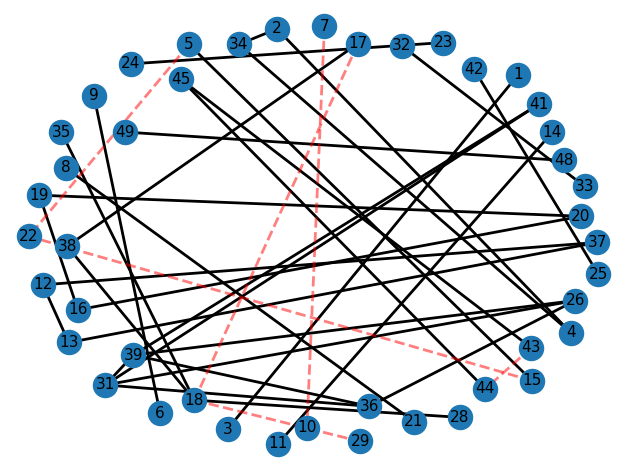

In [19]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()

for i in range(len(adj_est)):
    for j in range(len(adj_est[i])):
        if(adj_est[i][j] > 0):
            G.add_edge(i, j)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if v not in bad_edges_arr]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if v in bad_edges_arr]

pos = nx.spring_layout(G,k=9000, seed=8000)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=300)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=2)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="r", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=11, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(-0.01)
plt.axis("off")
plt.tight_layout()
plt.show()

In [20]:
# +--------------------+
avg_error /= cal_count
avg_KL /= cal_count
avg_mis /= cal_count
# +--------------------+
f = open("+ICITE-LSTM_GAN_GCN-rror.txt", 'a+')
#f = open("+KAIST-LSTM_GAN_GCN-error.txt", 'a+')
f.write('Avg. Error %f' % (avg_error))
f.write('\n')
f.close()
# +--------------------+
f = open("+ICITE-LSTM_GAN_GCN-KL.txt", 'a+')
#f = open("+KAIST-LSTM_GAN_GCN_KL.txt", 'a+')
f.write('Avg. KL %f' % (avg_KL))
f.write('\n')
f.close()
# +--------------------+
f = open("+ICITE-LSTM_GAN_GCN-mis.txt", 'a+')
#f = open("+KAIST-LSTM_GAN_GCN-mis.txt", 'a+')
f.write('Avg. Mis %f' % (avg_mis))
f.write('\n')
f.close()

Graph Output:

Error Bar:
Represents the error in precents between the predicted network is to the
ground-truth network.

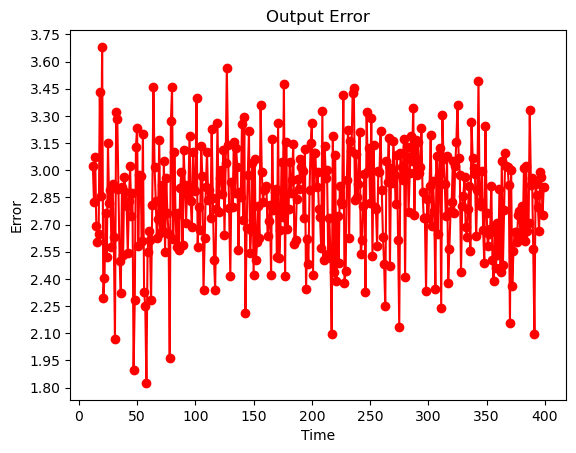

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# # Histogram:
# plt.bar(time_num_array, error_array, color = 'r', label = 'File Data')

# plt.xlabel('Time', fontsize = 12)
# plt.ylabel('Error', fontsize = 12)

# plt.title('Output Error', fontsize = 20)
# plt.legend()
# plt.show()


# linear graph:
plt.title("Output Error")
plt.xlabel('Time')
plt.ylabel('Error')

# Set the number of desired ticks on the y-axis
num_ticks = 15
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(num_ticks))
plt.plot(time_num_array, error_array, marker = 'o', c = 'r')

plt.show()

Avg KL:
edge-wise KL-divergence to further consider the magnitude difference of link weights


This value shows us the Kullback-Leibler divergence from each iteration,
The KL value is parameter that tells us how similar the predicted network is
to the ground-truth network.

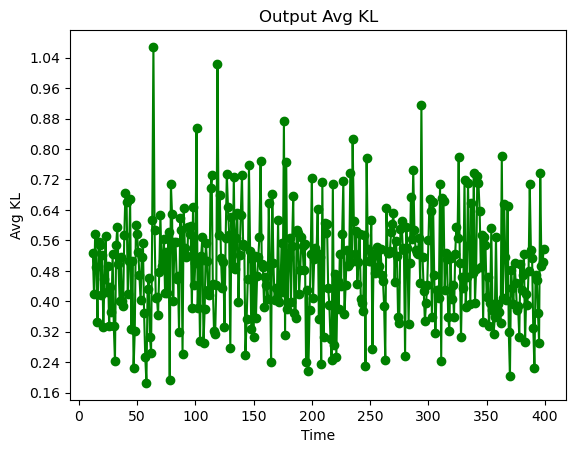

In [22]:
# # Histogram:
# plt.bar(time_num_array, avg_KL_array, color = 'g', label = 'File Data')

# plt.xlabel('Time', fontsize = 12)
# plt.ylabel('Avg KL', fontsize = 12)

# plt.title('Output Avg KL', fontsize = 20)
# plt.legend()
# plt.show()

# linear graph:
plt.title("Output Avg KL")
plt.xlabel('Time')
plt.ylabel('Avg KL')
# Set the number of desired ticks on the y-axis
num_ticks = 15
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(num_ticks))
plt.plot(time_num_array, avg_KL_array, marker = 'o', c = 'g')

plt.show()


Avg Mis:
Mismatch rate, which represents the proportion of such mismatched edges in a certain graph snapshot, as an additional evaluation metric

The paper introduced another evaluation method which is the mismatch
rate, that represents the proportion of mismatch edges on the graph
snapshot, as an additional evaluation metric.

In [23]:
# # Histogram
# plt.bar(time_num_array, avg_mis_array, color = 'b', label = 'File Data')
 
# plt.xlabel('Time', fontsize = 12)
# plt.ylabel('Avg Mis', fontsize = 12)

# plt.title('Output Avg Mis', fontsize = 20)
# plt.legend()
# plt.show()


# # linear graph:
# plt.title("Output Avg Mis")
# plt.xlabel('Time')
# plt.ylabel('Avg Mis')
# # Set the number of desired ticks on the y-axis
# num_ticks = 15
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(num_ticks))
# plt.plot(time_num_array, avg_mis_array, marker = 'o', c = 'b')

# plt.show()
